<img src="./logo_UTN.svg" align="right" width="150" /> 
#### Procesamiento Digital de Señales

# Tarea Semanal Nº4
#### Gisela Farace

## Consigna

#### Simulación de un ADC (cuantización) parte 2/2 <br>
En esta tarea semanal retomamos la consigna de la tarea anterior, donde simulamos el bloque de cuantización de un ADC de B bits en un rango de ±$V_{F}$ Volts. Ahora vamos a completar la simulación del ADC incluyendo la capacidad de muestrear a fs Hertz.

Para ello se simulará el comportamiento del dispositivo al digitalizar una senoidal contaminada con un nivel predeterminado de ruido. Comenzaremos describiendo los parámetros a ajustar de la senoidal:

* frecuencia $f_{0}$ arbitraria, por ejemplo $f_{0}=f_{S/N}=Δf$, 
* energía normalizada, es decir energía (o varianza) unitaria

Con respecto a los parámetros de la secuencia de ruido, diremos que:

* será de carácter aditivo, es decir la señal que entra al ADC será $s_{R}=s+n$. Siendo n la secuencia que simula la interferencia, y s la senoidal descrita anteriormente.
* La potencia del ruido será $Pn=kn.Pq W$ siendo el factor k una escala para la potencia del ruido de cuantización $Pq=\frac{q^{2}}{12}$
* finalmente, n será incorrelado y Gaussiano.

El ADC que deseamos simular trabajará a una frecuencia de muestreo $f_{S}$=1000 Hz y tendrá un rango analógico de ±$V_{F}=2$ Volts.

## Código

### Importación de librerias

In [26]:
# Importación de módulos para Jupyter

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.signal as sig

#Presentación de los gŕaficos
mpl.rcParams['figure.figsize'] = (30,40)
fig_sz_x = 14
fig_sz_y = 13
fig_dpi = 80 # dpi

fig_font_family = 'Ubuntu'
fig_font_size = 16

plt.rcParams.update({'font.size':fig_font_size})
plt.rcParams.update({'font.family':fig_font_family})

### Funciones

In [27]:
def senoidal(vmax, dc, ff, ph, nn, fs):
    ts = 1/fs # tiempo de muestreo
    df = fs/nn # resolución espectral 
    
    # grilla de sampleo temporal
    tt = np.linspace(0, (nn-1)*ts, nn).flatten()
    
    # grilla de sampleo frecuencial
    sen = vmax*np.sin(2*np.pi*ff*tt + ph)+dc
    
    return tt, sen

def cuantizacion(B, Vref, xx):
    q = Vref/2**(B) #Volts
    x = np.round(xx/q)
    xq = x*q
    error = xq - xx
    
    return xq, error, q

def fft(xx, N):
    ft = np.fft.fft(xx, axis=0)
    ft = ft/N
    return ft

In [28]:
## Función para graficar:
## 1) Señal analogica, señal con ruido y señal cuantizada
## 2) densidad espectral de potencia
## 3) histograma del ruido de cuantización

def analisis_adc(xx, tt, fs, N, B, Vref, kn):
    df = fs/N # resolución espectral
         
    #ADC
    q = Vref/2**(B) #Volts
    
    # Datos ruido
    pot_ruido = q**2/12 * kn # Watts (potencia de la señal 1 W)
    desv = np.sqrt(pot_ruido)
    # Ruido incorrelado y gaussiano
    n = np.random.normal(0,desv, size=N)
    # Señal contaminada con ruido
    sr = analog_sig + n
    #ADC
    srq, nq, q = cuantizacion(B, Vref, sr)
    
    # Presentación gráfica de los resultados  
    fig, axs = plt.subplots(3)
    axs[0].plot(tt, srq, lw=2)
    axs[0].plot(tt, sr, linestyle=':', color='green',marker='o', markersize=3, markerfacecolor='none', markeredgecolor='green', fillstyle='none')
    axs[0].plot(tt, analog_sig, color='orange', ls='dotted')
    axs[0].legend(['$ s_Q = Q_{B,V_F}\{s_R\} $ (ADC out)','$ s_R = s + n $  (ADC in)', '$ s $ (analog)'])
    axs[0].set_title('Señal muestreada por un ADC de {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V - kn = {:3.1f}'.format(B, Vref, q, kn) )
    axs[0].set(xlabel='tiempo [segundos]', ylabel='Amplitud [V]')
    axes_hdl = plt.gca()
     
    # Densidad espectral de potencia
    ff = np.linspace(0, (N-1), N)*df
    ff_os = ff
    ft_Srq = fft(srq,N)
    ft_As = fft(analog_sig,N)
    ft_SR = fft(sr,N)
    ft_Nn = fft(n,N)
    ft_Nq = fft(nq,N)
    
    nNn_mean = np.mean(np.abs(ft_Nn)**2)
    Nnq_mean = np.mean(np.abs(ft_Nq)**2)
    
    bfrec = ff <= fs/2
    
    axs[1].plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Srq[bfrec])**2), lw=2 )
    axs[1].plot( ff_os[ff_os <= fs/2], 10* np.log10(2*np.abs(ft_As[ff_os <= fs/2])**2), color='orange', ls='dotted' )
    axs[1].plot( ff[bfrec], 10* np.log10(2*np.abs(ft_SR[bfrec])**2), ':g')
    axs[1].plot( ff_os[ff_os <= fs/2], 10* np.log10(2*np.abs(ft_Nn[ff_os <= fs/2])**2), ':r')
    axs[1].plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Nq[bfrec])**2), ':c')
    axs[1].plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2* np.array([nNn_mean, nNn_mean]) ), '--r')
    axs[1].plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2* np.array([Nnq_mean, Nnq_mean]) ), '--c')
    axs[1].set_title('Señal muestreada por un ADC de {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V- kn = {:3.1f}'.format(B, Vref, q, kn))
    axs[1].legend(['$ s_Q = Q_{B,V_F}\{s_R\} $ (ADC out)','$ s $ (analog)','$ s_R = s + n $  (ADC in)','$ \overline{n} = $' + '{:3.1f} dB (piso analog.)'.format(10* np.log10(2* nNn_mean)),'$ \overline{n_Q} = $' + '{:3.1f} dB (piso digital)'.format(10* np.log10(2* Nnq_mean)) ])
    axs[1].set(xlabel='Frecuencia [Hz]', ylabel='Densidad de Potencia [dB]')
    axes_hdl = plt.gca()
    # suponiendo valores negativos de potencia ruido en dB
    axs[1].set_ylim((1.5*np.min(10* np.log10(2* np.array([Nnq_mean, nNn_mean]))),10))
    
    # Histograma
    bins = 10
    axs[2].hist(nq, bins=bins)
    axs[2].plot( np.array([-q/2, -q/2, q/2, q/2]), np.array([0, N/bins, N/bins, 0]), '--r' )
    axs[2].set_title( 'Ruido de cuantización para {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V - kn = {:3.1f}'.format(B, Vref, q, kn))
    
    return

### Datos 

In [29]:
# datos de la senoidal
vmax = 1
dc = 0
ff = 1
ph = 0
N = 1000  # cantidad de muestras
fs = 1000 # frecuencia de muestreo (Hz)

# Datos del ADC
Vref = 2 # Volts
B = 4

# datos del ruido
kn = 1

### Análisis para una señal senoidal

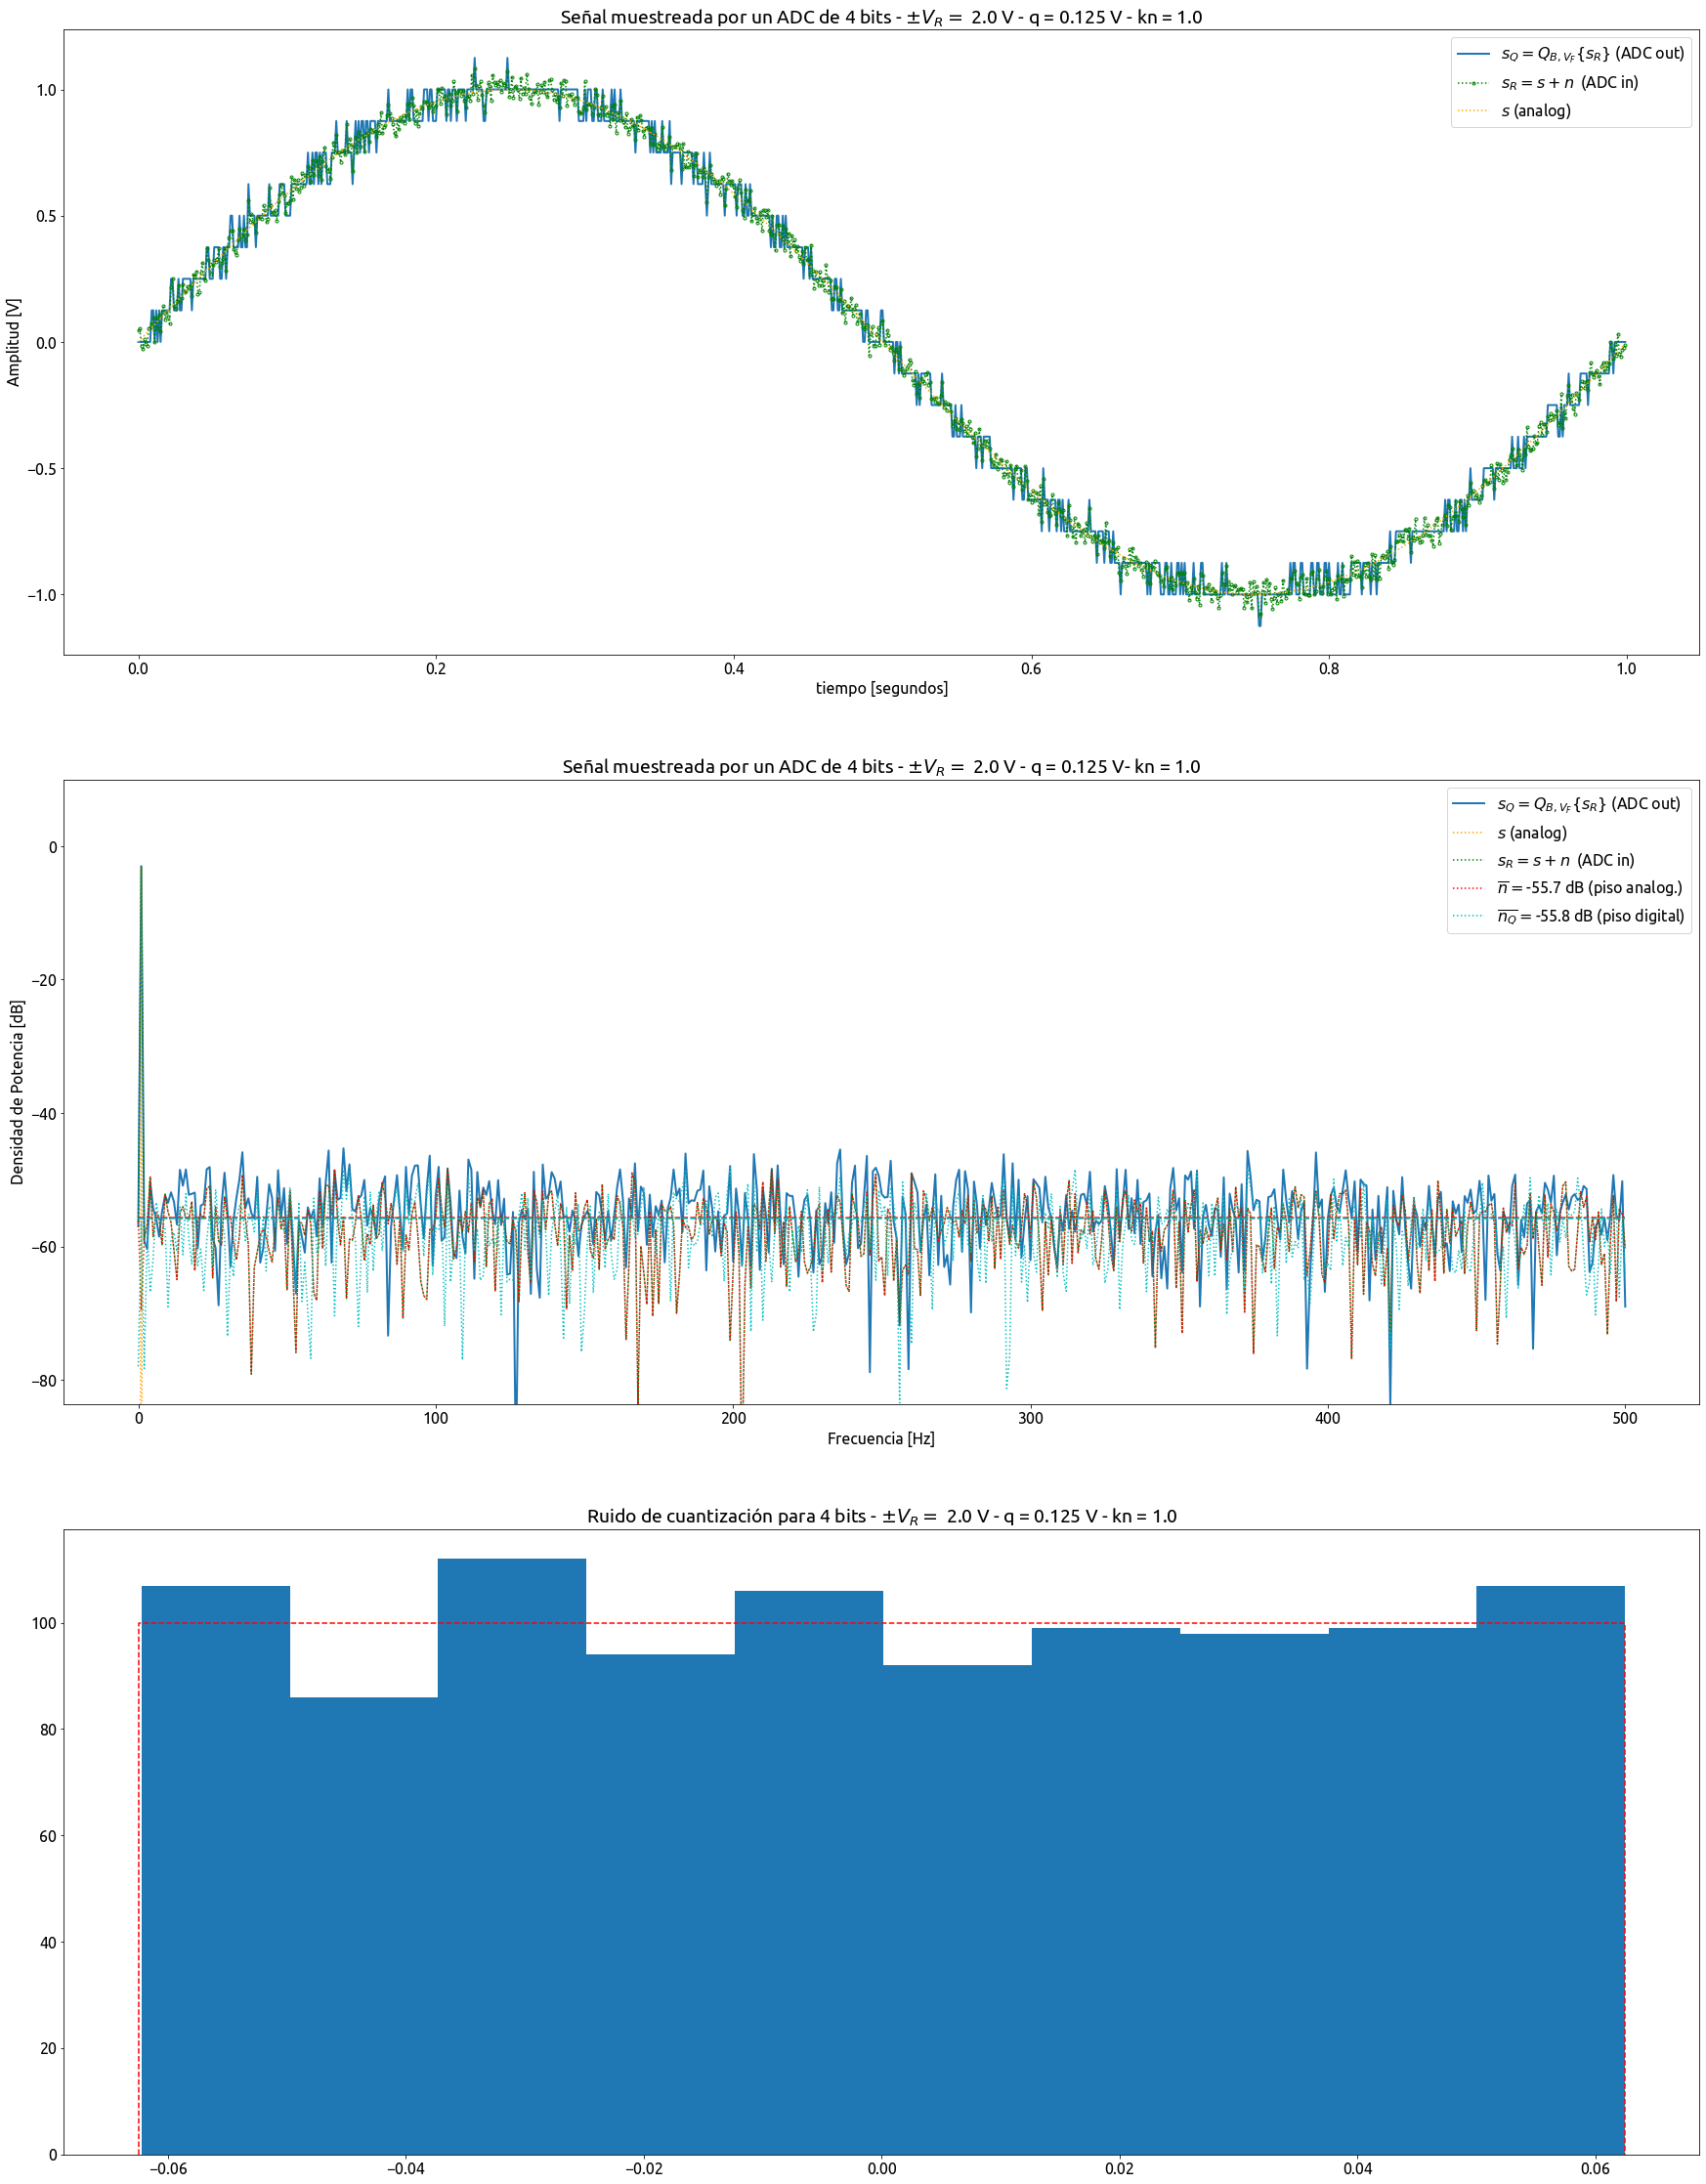

In [30]:
# Senoidal
tt,analog_sig = senoidal(vmax, dc, ff, ph, N, fs)

analisis_adc(analog_sig, tt, fs, N, B, Vref, kn)

### Encontrar la relación entre la cantidad de B bits del ADC y el SNR de la señal digitalizada.

La potencia del ruido se define como su varianza, como se indica en el enunciado:

$Pn=k_{n}.\frac{q^{2}}{12} [W]$ donde el factor $k_{n}$ una escala para la potencia del ruido de cuantización 

Siendo $q = \frac{V_{ref}}{2^{B}}$

La varianza del ruido será: $\sigma_{n}^{2} = k_{n}\frac{V_{ref}^{2}}{12.2^{2B}} $ <br>
Donde B es la cantidad de bits del conversor y $V_{ref}$ el rango del conversor

La relación señal a ruido de una señal $x[n]$ se define como

$ SNR = 10.log_{10} \frac{\sigma_{x}^{2}}{\sigma_{n}^{2}} = 10.log_{10}\frac{\sigma_{x}^{2}}{\frac{k_{n}.V_{ref}^{2}}{12.2^{2B}}} = 10.log_{10}\frac{12.2^{2B}\sigma_{x}^{2}}{k_{n}.V_{ref}^{2}} = 6.02B + 10.79 + 20.log_{10} \frac{\sigma_{x}}{k_{n}.V_{ref}^{2}}$

La señal a ruido depende entonces de:
* la resolución del conversor, B
* la desviación estandar de la señal,$\sigma_{x}$ 
* el rango máximo del conversor, $V_{ref}$

Cada bit adicional de resolución aumenta la SNR en 6dB aproximadamente. <br>
Además, se puede observar en el último término $20.log_{10} \frac{\sigma_{x}}{k_{n}.V_{ref}^{2}}$ que al aumentar el factor $k_{n}$ resulta en una disminución de dicho término, reduciendo la SNR.

### Para distintos valores de B y kn

Analizar para una de las siguientes configuraciones B = ̣{4, 8 y 16} bits, kn={1/10,1,10}. Discutir los resultados respecto a lo obtenido antes

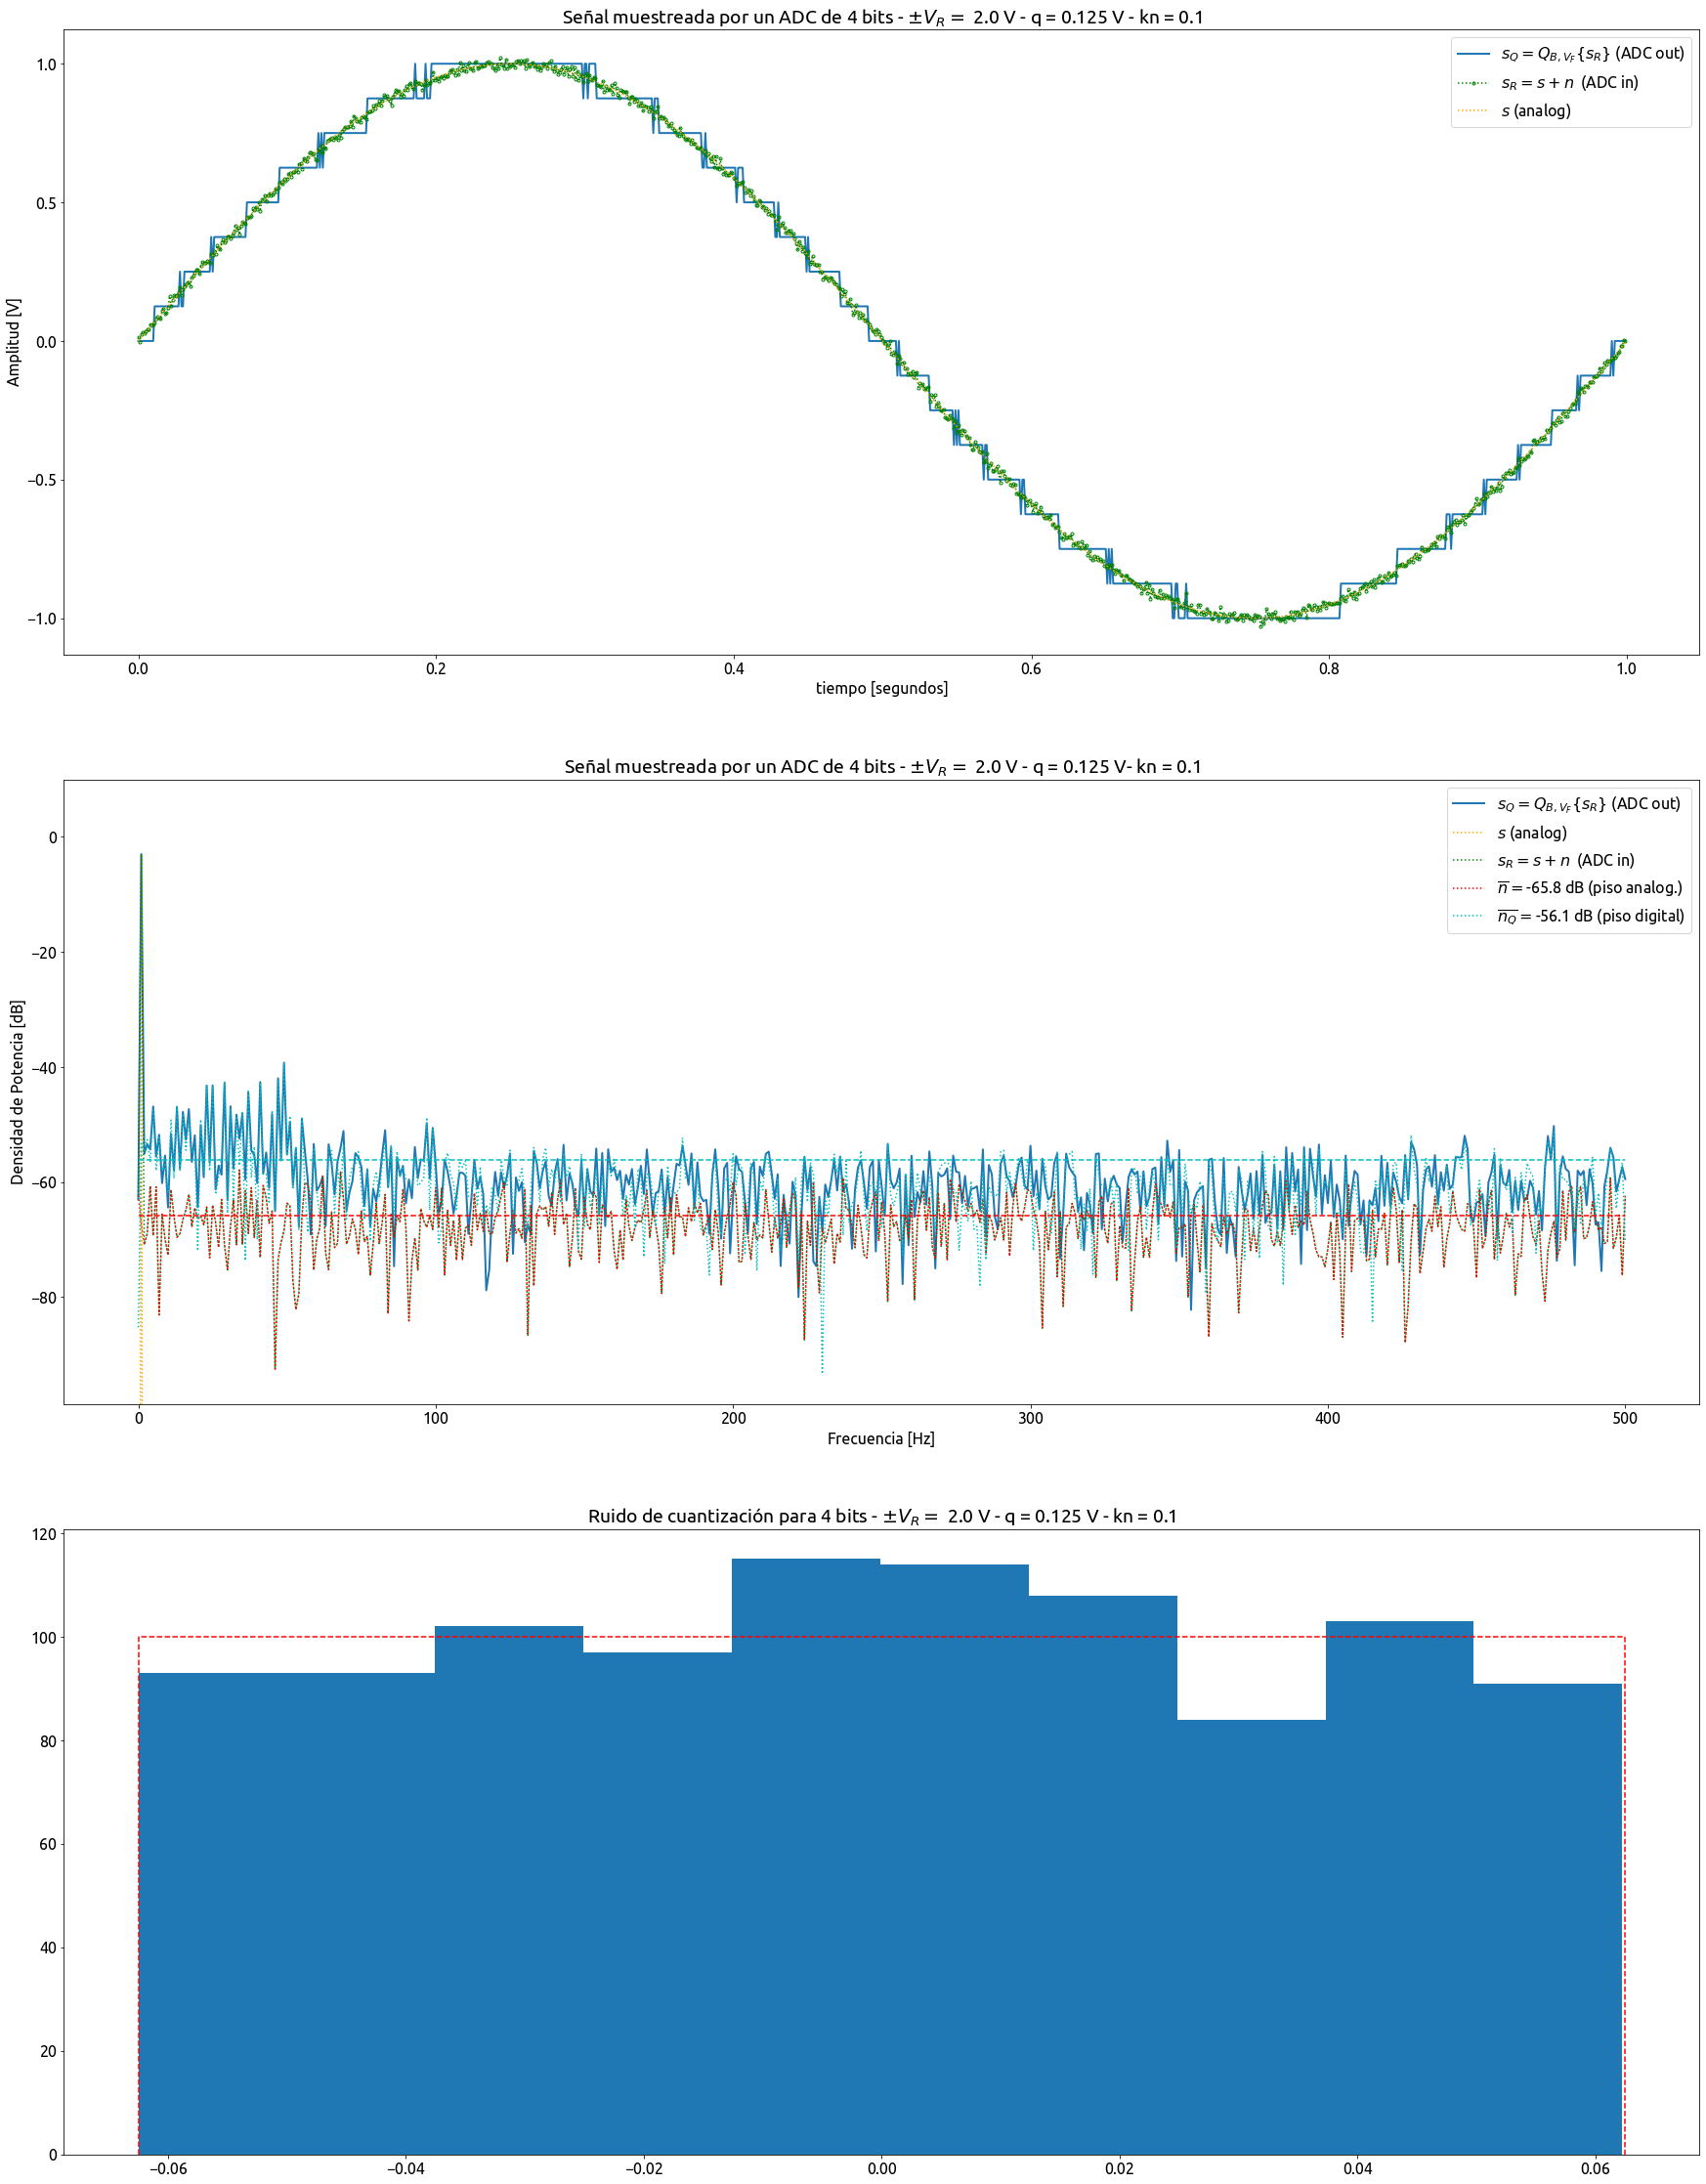

In [31]:
B = 4
kn = 1/10
analisis_adc(analog_sig, tt, fs, N, B, Vref, kn)

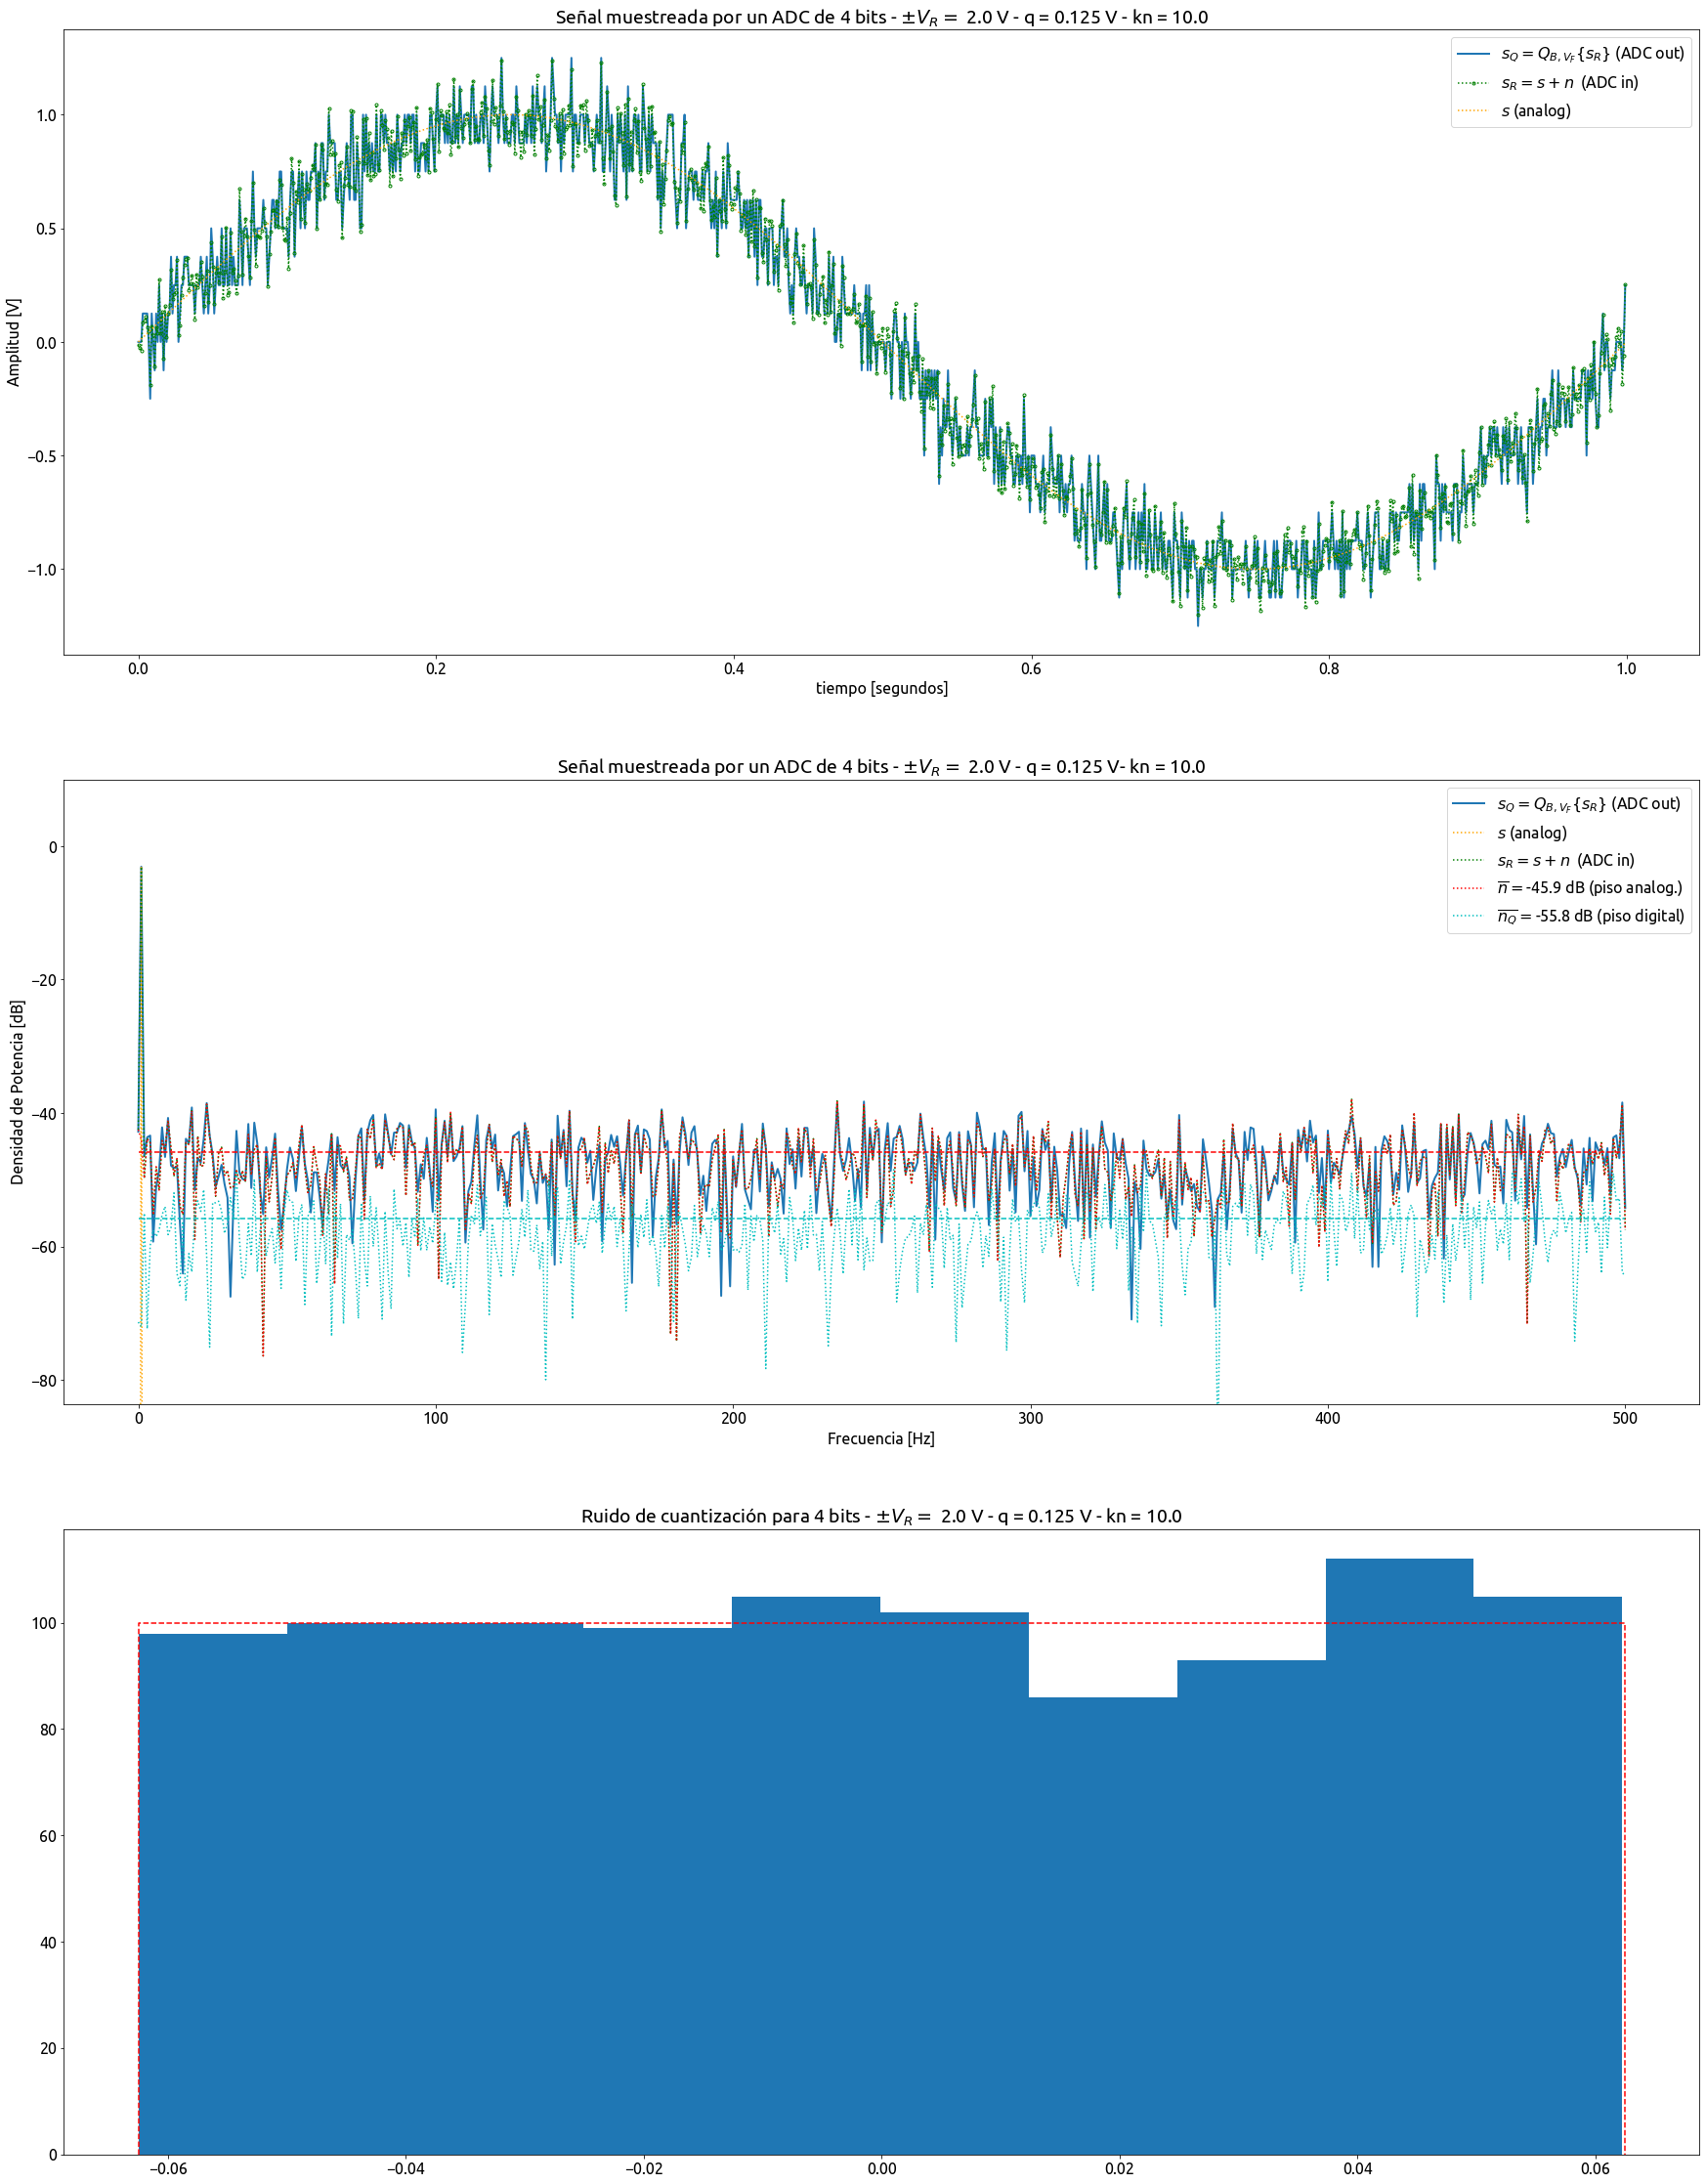

In [32]:
B = 4
kn = 10
analisis_adc(analog_sig, tt, fs, N, B, Vref, kn)

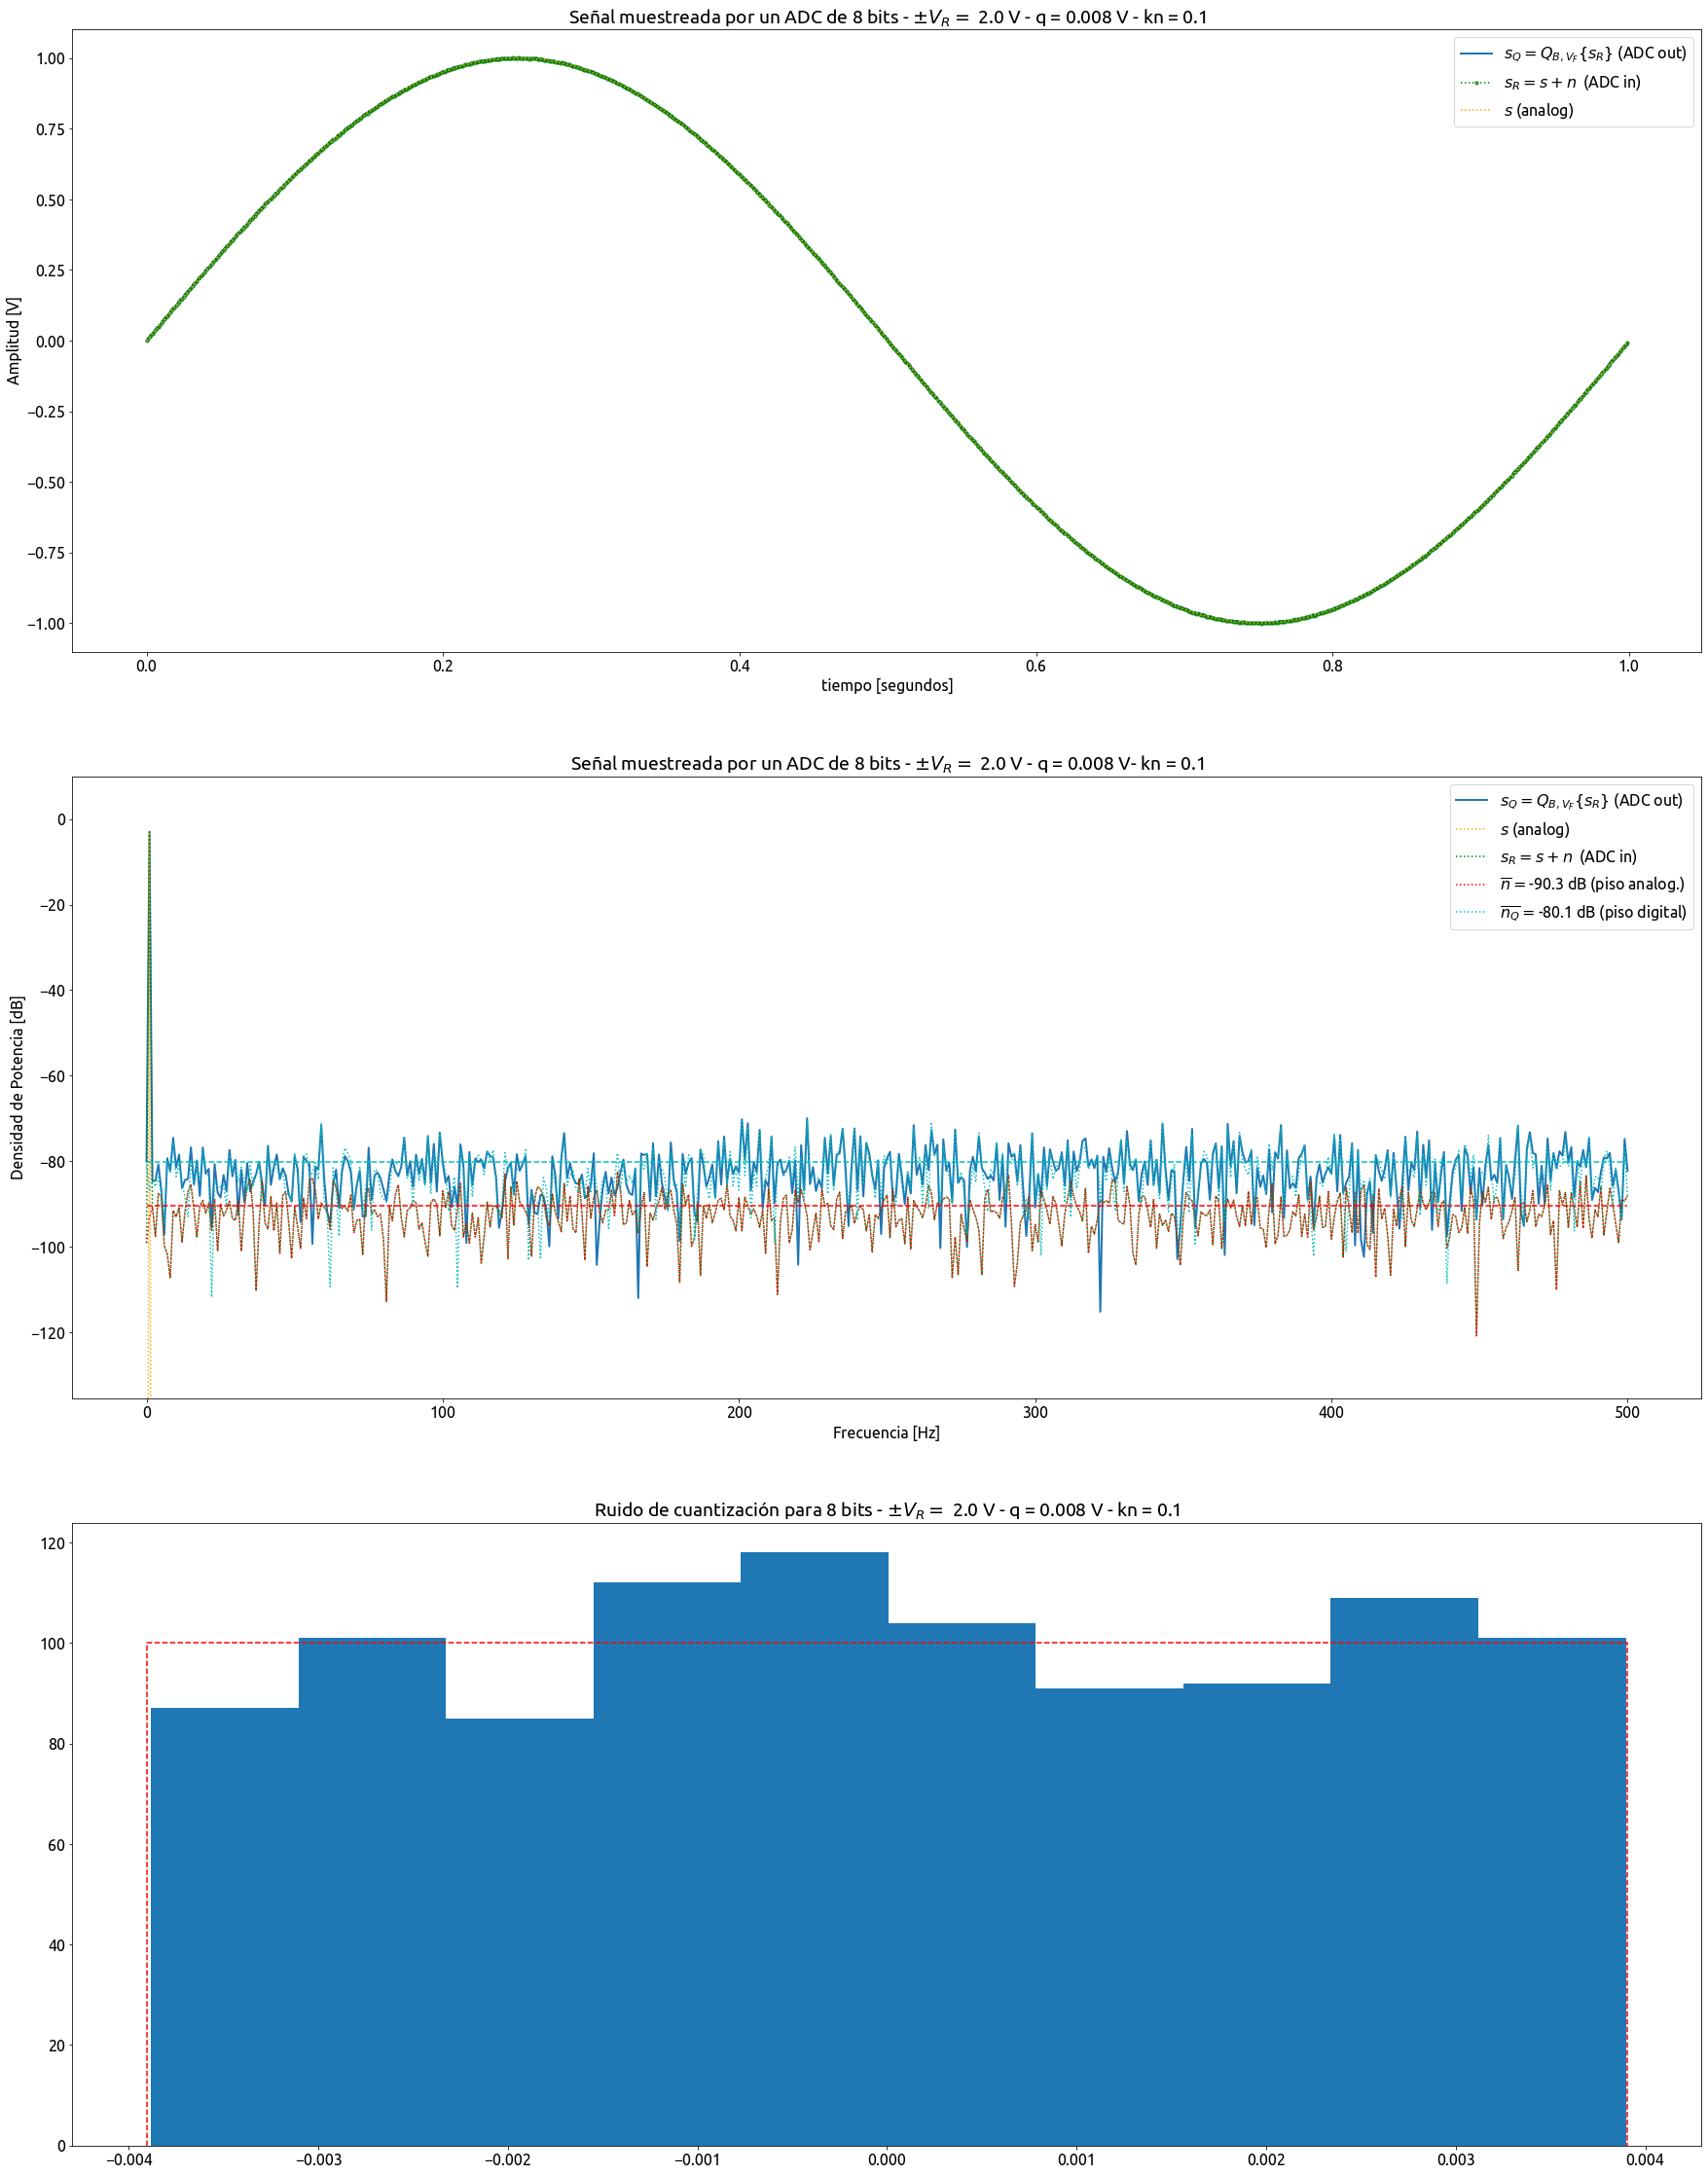

In [33]:
B = 8
kn = 1/10
analisis_adc(analog_sig, tt, fs, N, B, Vref, kn)

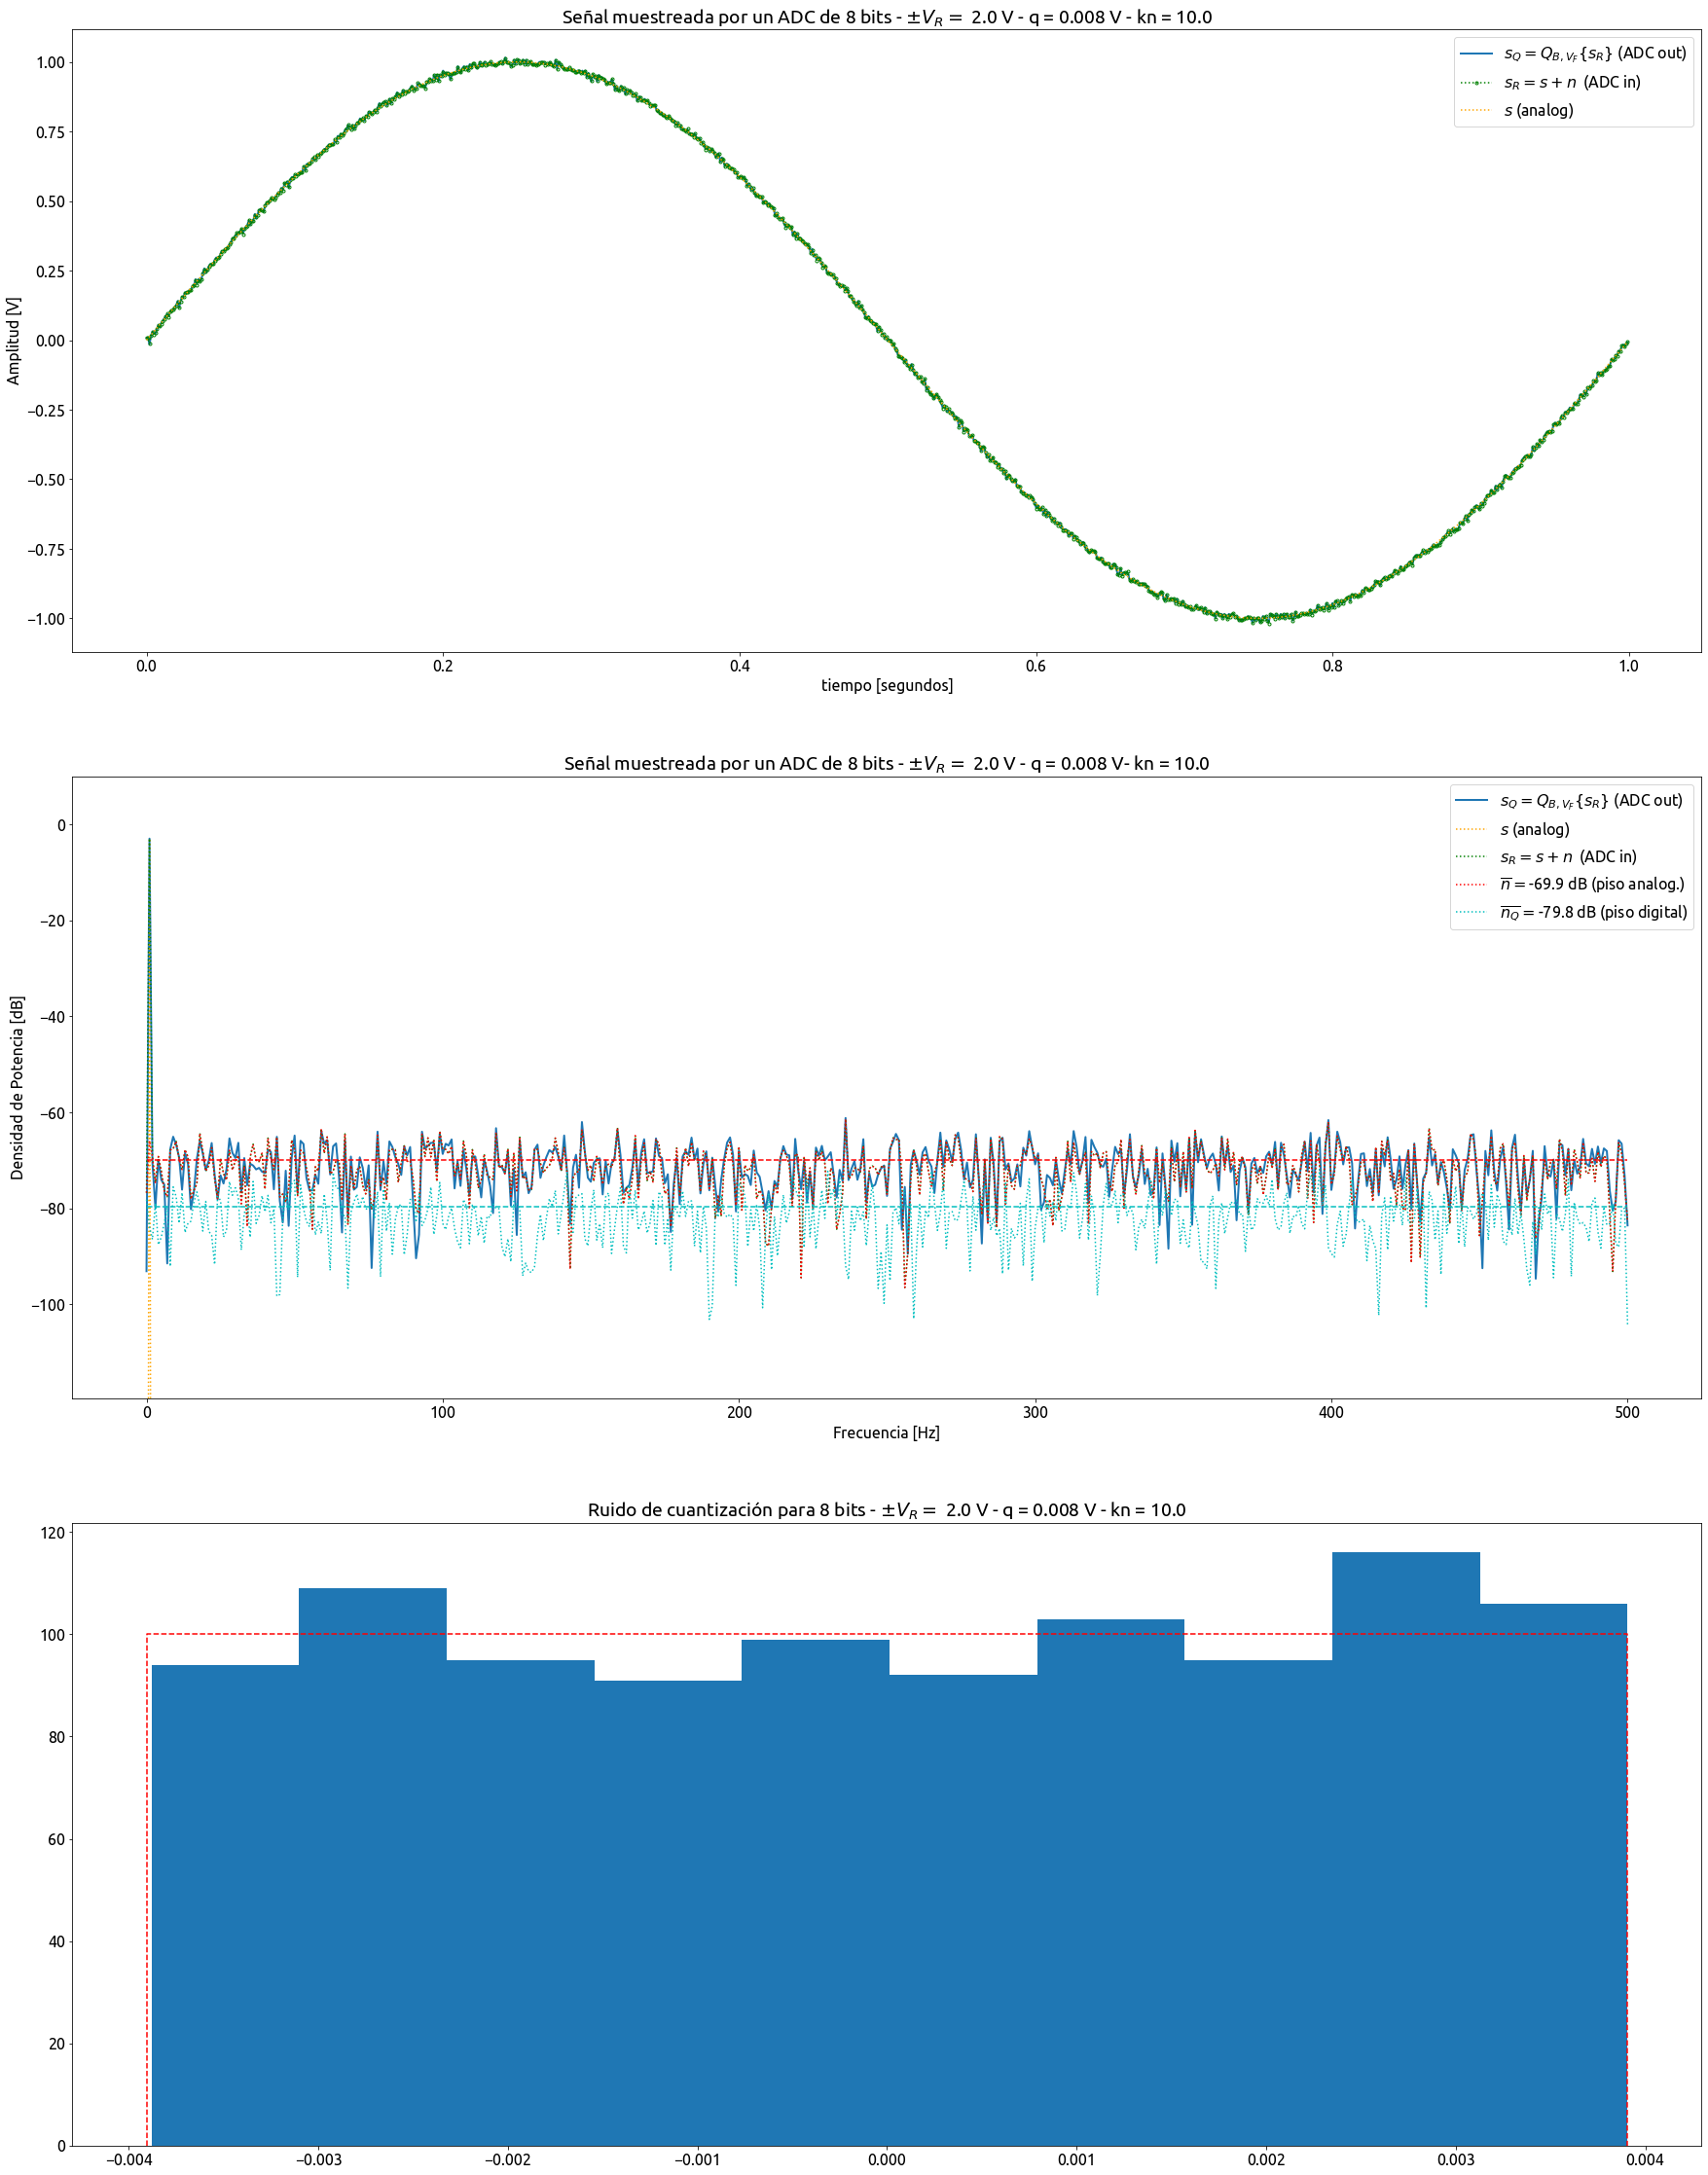

In [34]:
B = 8
kn = 10
analisis_adc(analog_sig, tt, fs, N, B, Vref, kn)